<a href="https://colab.research.google.com/github/VDidyk/AI/blob/master/module3/%D0%94%D0%97_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module2/data/ship_passengers.csv",
                 index_col="Unnamed: 0")

In [3]:
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [4]:
df = df[['pclass', 'age', 'embarked', 'fare']]
df.head()

,pclass,age,embarked,fare
0,3,22.0,S,7.2500
1,1,38.0,C,71.2833
2,3,26.0,S,7.9250
3,1,35.0,S,53.1000
4,3,35.0,S,8.0500


# Завдання 1
Очистіть дані від викидів(лише `fare`), розділіть на тренувальну та тестову чатини

In [5]:
def remove_outliers(df, column_name):
  column = df[column_name]

  q1 = column.quantile(q=0.25)
  q3 = column.quantile(q=0.75)

  iqr = q3 - q1

  lower = q1 - 1.5*iqr
  upper = q3 + 1.5*iqr

  mask = (column >= lower) & (column <= upper)

  return df[mask]


df = remove_outliers(df, "fare")

In [6]:
df.dropna(subset=["fare"], inplace=True)

In [7]:
y = df['fare']
X = df.drop(columns='fare')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Завдання 2
Створіть Pipeline для обробки даних

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

num_columns = X.select_dtypes(include="number").columns

num_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

In [9]:
cat_columns = X.select_dtypes(include="object").columns
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ])

# Завдання 3
Створіть остаточну модель та натренуйте її

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['pclass', 'age'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 Index(['embarked'], dtype='object'))])

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import tree

def create_model(depth):
  return Pipeline(
    [
        ("prep", preprocessor),
        ("model", tree.DecisionTreeRegressor(max_depth=depth, max_features=10))
    ]
  )

model = create_model(4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['pclass', 'age'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['embarked'], dtype='object'))])),
                ('model', DecisionTreeRegressor(max_depth=4, max_features=10))])

# Завдання 4
Виведіть основні метрики моделі

In [12]:
from sklearn import metrics

def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, y_pred)

all_metrics

,train,test
MAE,6.27,8.57
RMSE,8.77,13.27
R2,0.53,0.30


# Завдання 5
Змініть параметри моделі та попробуйте покращити результат

Попробуйте:
* не видаляти викиди
* змінити обробку даних(imputer та кодування категоріальних даних)
* змінити параметри дерева(глибина, кількість точок у листках тощо

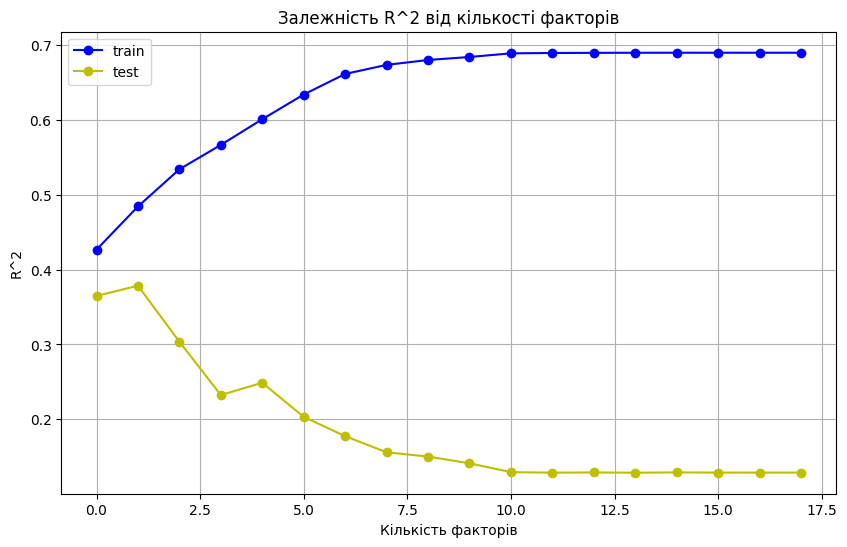

In [30]:
import matplotlib.pyplot as plt

r2_train = []
r2_test = []

for i in range(2,20):
  model = create_model(i)
  model.fit(X_train, y_train)
  y_pred= model.predict(X_train)

  r2_train.append(metrics.r2_score(y_train, y_pred))
  r2_test.append(metrics.r2_score(y_test, model.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(r2_train, marker='o', linestyle='-', color='b', label='train')
plt.plot(r2_test, marker='o', linestyle='-', color='y', label='test')
plt.title('Залежність R^2 від кількості факторів')
plt.xlabel('Кількість факторів')
plt.ylabel('R^2')
plt.legend()
plt.grid(True)
plt.show()


# Завдання 6
Збережіть модель

In [ ]:
import joblib

file_path = 'model.pkl'

joblib.dump(model, file_path)

['model.pkl']

model2 = joblib.load(file_path)